In [930]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from timeit import default_timer as timer

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

### Generate Data

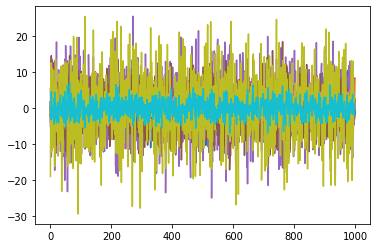

In [1028]:
T, p, edges_per_var = 1000, 20, 2
graph_type, sem_type = 'ER', 'gauss'
s0 = int(min(edges_per_var * p, p * (p - 1) / 2))

B_true = utils.simulate_dag(p, s0, graph_type)
W_true = utils.simulate_parameter(B_true, w_ranges = ((-0.50, -2.00), (0.50, 2.00)))
X = utils.simulate_linear_sem(W_true, T, sem_type)
plt.plot(X);

### Extract Features as Atoms and Labels as Initial Residual

In [1029]:
def normalize(x): return x / np.linalg.norm(x, 2)

# compute atoms, residuals
W = np.zeros((p, p))
atoms = np.array([X[:, i] for i in range(p)])
residuals = np.array([X[:, j] for j in range(p)])
Theta = np.array([np.dot(y.T, y) for y in residuals])

# double check, gains of first iteration
# inner product without summation, could be useful before removing
gains = np.array([np.abs(normalize(X[:, i]) @ (X[:, j])) for j in range(p) for i in range(p)])

print(np.shape(gains))
print(np.shape([(atoms[i] * residuals[j]) for i in range(p) for j in range(p)]))

(400,)
(400, 1000)


### Kernel OMP

In [1030]:
def K_OMP(Psi, K, Theta, X, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""

    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    n = np.shape(Psi)[0]

    if is_sem: F = [i * (n + 1) for i in range(n)]
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas, Ws = [[] for _ in range(n)], [], np.zeros((n, n)), []
    
    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X]

    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
        # stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: 
            break

        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n

        if row not in Lambda[col]: Lambda[col].append(row)
        else: print("A")
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)
            F.append(row * n + col)
            
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.pinv(Psi_F) @ K[np.array(idx)[:, None], col]
            
            Ws.append(betas.copy())
            
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            if len(np.nonzero(betas)[0]) >= max_coefs: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
#         # check residual squared
#         print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
#         print(row, col)

        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, Ws, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)])


In [1031]:
W, Ws, r = K_OMP(X.T.dot(X), X.T.dot(X), [np.dot(y.T, y) for y in X.T], X.T, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True)
print(np.shape(Ws))
utils.count_accuracy(W_true, W != 0)

(190, 20, 20)


{'fdr': 0.7894736842105263, 'tpr': 1.0, 'fpr': 1.0, 'shd': 150, 'nnz': 190}

### OMP on Subsets

In [1032]:
# Extract subset
k = range(0, T//2)
X_del = np.delete(X, k, axis = 0)
atoms_del = np.delete(atoms, k, axis = 1)
residuals_del = np.delete(residuals, k, axis = 1)
print(np.shape(X_del))
print(np.shape(atoms_del))

# Perform OMP
W, Ws, r = K_OMP(X_del.T.dot(X_del), X_del.T.dot(X_del), [np.dot(y.T, y) for y in X_del.T], X_del.T, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True, tol = -0.99)
print(np.shape(Ws))
W, Ws, r = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True, tol = -0.99)
print(np.shape(Ws))
utils.count_accuracy(W_true, W != 0)

(500, 20)
(20, 500)
(190, 20, 20)
(190, 20, 20)


{'fdr': 0.7894736842105263, 'tpr': 1.0, 'fpr': 1.0, 'shd': 150, 'nnz': 190}

### $k$-Fold Cross validation

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Remove entries 601 until 700.	[700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799]
Remove entries 701 until 800.	[800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887

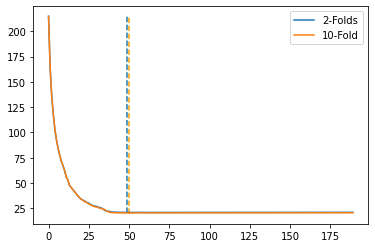

In [1033]:
def k_fold_cross_validation(num_splits, verbose = True):
    mses_avg = []

    for i in range(num_splits):
        k = range(i * T // num_splits, min((i + 1) * T // num_splits, T))
    
        # just to be safe when num_splits is larger than T
        if len(k) >= 1:
            print(list(k))
            # remove atoms, do OMP
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y, y.T) for y in residuals_del], atoms_del, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True, tol = -1e-4)
    
            # append mse on middle test percentage of test set
            mses_avg.append([1 / (len(k)) * np.linalg.norm(X[k] - X[k] @ W, 'f') ** 2 for W in Ws])
            if verbose: print(f"Remove entries {k[0] + 1} until {k[-1] + 1}." , end = "\t")
            
    return mses_avg

num_splits = 10
two_fold_mses = k_fold_cross_validation(2)
more_fold_mses = k_fold_cross_validation(num_splits)
print(np.shape(two_fold_mses))
# plot results
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)), min(np.mean(np.array(two_fold_mses), axis = 0)) - 1, max(np.mean(np.array(two_fold_mses), axis = 0)), linestyle = "--")
plt.plot(np.mean(np.array(two_fold_mses), axis = 0), label = "2-Folds")

plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)), min(np.mean(np.array(more_fold_mses), axis = 0)) - 1, max(np.mean(np.array(more_fold_mses), axis = 0)), linestyle = "--", color = "orange")
plt.plot(np.mean(np.array(more_fold_mses), axis = 0), label = f"{num_splits}-Fold")
plt.legend()

$$\begin{align*}R(f) &= \text{Tr}\left(\mathbb{E}\left[(Y - f(X))^2\right]\right) \\&= \text{Tr}\left(\mathbb{E}\left[(X - XW)^2\right]\right) \\  &=  \text{Tr}\left(\mathbb{E}\left[\left(X\left(I_p - W\right)\right)^2\right]\right) \\ &= \text{Tr}\left(\left(I_p - W\right)^T \mathbb{E}\left[X^2\right] \left(I_p - W\right)\right).\end{align*}$$

In [1034]:
def expected_MSE_X(W): return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def expected_cost_sem(W_true, W_est, Sigma = np.identity(p)):
    """Expected Cost of a Structural Equation Model with X = X W_est, when truth is X = X W_true"""
    
    # base on the distribution of X, no actual data needed.    
    covariance_matrix = (W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est- np.identity(p))
    
    # return expected MSE
    return np.trace(covariance_matrix)

print(expected_cost_sem(W_true, W))
print(h.MSE(W, utils.simulate_linear_sem(W_true, T * 1000, sem_type), is_sem = True))

20.384181742045097
20.382188734585675


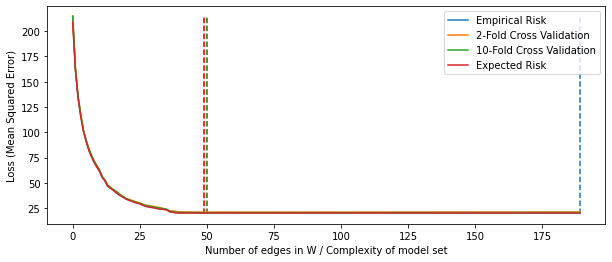

In [1035]:
# first l_lim are disregarded
l_lim = 0

# Compute emprirical risk, true risk
W, Ws, _ = K_OMP(atoms.dot(atoms.T), atoms.dot(residuals.T), [np.dot(y.T, y) for y in residuals], atoms, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True)
expected_cost = [expected_cost_sem(W_true, W) for W in Ws]

# Plot empirical risk, cross validated risk, true risk.
plt.figure(figsize = (10, 4))
plt.plot([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]], label = "Empirical Risk")
plt.plot(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:], label = f"2-Fold Cross Validation")
plt.plot(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:], label = f"{num_splits}-Fold Cross Validation")
plt.plot([expected_cost_sem(W_true, W) for W in Ws[l_lim:]], label = "Expected Risk")

# Show minimizers of empirical risk, cross validated risk, true risk
min_vlines = np.min((np.array([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))
max_vlines = np.max((np.array([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]]), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]))
plt.vlines(np.argmin(np.array([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]])), min_vlines - 1, max_vlines, linestyle = "--")
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:]) + 0.01, min_vlines - 1, max_vlines, color = "orange", linestyle = "--")
plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:] + 0.02), min_vlines - 1, max_vlines, color = "g", linestyle = "--")
plt.vlines(np.argmin([expected_cost_sem(W_true, W) for W in Ws[l_lim:]]) + 0.03, min_vlines - 1, max_vlines, color = "r", linestyle = "--")

# Show legend
plt.ylabel("Loss (Mean Squared Error)")
plt.xlabel("Number of edges in W / Complexity of model set")
plt.legend()

In [1036]:
index = 40
W_thresh = W.copy()
W_thresh[np.abs(W_thresh) <= 0.30] = 0
print(f"Empirical Risk Minimizer:\t{utils.count_accuracy(W_true != 0, Ws[np.argmin(np.array([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]]))] != 0)}.")
print(f"Naive Risk Minimizer:\t\t{utils.count_accuracy(W_true != 0, W_thresh != 0)}.")
print(f"Two Fold Risk Minimizer:\t{utils.count_accuracy(W_true != 0, Ws[np.argmin(np.mean(np.array(two_fold_mses), axis = 0)[l_lim:])] != 0)}.")
print(f"{num_splits} Fold Risk Minimizer:\t\t{utils.count_accuracy(W_true != 0, Ws[np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:])] != 0)}.")
print(f"Expected Risk Minimizer: \t{utils.count_accuracy(W_true != 0, Ws[np.argmin([expected_cost_sem(W_true, W) for W in Ws[l_lim:]])] != 0)}.")

Empirical Risk Minimizer:	{'fdr': 0.7894736842105263, 'tpr': 1.0, 'fpr': 1.0, 'shd': 150, 'nnz': 190}.
Naive Risk Minimizer:		{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 40}.
Two Fold Risk Minimizer:	{'fdr': 0.2, 'tpr': 1.0, 'fpr': 0.06666666666666667, 'shd': 10, 'nnz': 50}.
10 Fold Risk Minimizer:		{'fdr': 0.21568627450980393, 'tpr': 1.0, 'fpr': 0.07333333333333333, 'shd': 11, 'nnz': 51}.
Expected Risk Minimizer: 	{'fdr': 0.2, 'tpr': 1.0, 'fpr': 0.06666666666666667, 'shd': 10, 'nnz': 50}.


In [1037]:
print(f"Naive Minimal Risk:\t{expected_cost_sem(W_true, W_thresh)}.")
print(f"Empirical Minimal Risk:\t{expected_cost_sem(W_true, Ws[np.argmin(np.array([h.MSE(W, X, is_sem = True) for W in Ws[l_lim:]]))])}.")
print(f"Two Fold Minimial Risk:\t{expected_cost_sem(W_true, Ws[np.argmin(np.mean(np.array(two_fold_mses), axis = 0))])}.")
print(f"{num_splits} Fold Minimal Risk:\t{expected_cost_sem(W_true, Ws[np.argmin(np.mean(np.array(more_fold_mses), axis = 0)[l_lim:])])}.")
print(f"True Minimial Risk:\t{expected_cost_sem(W_true, Ws[np.argmin([expected_cost_sem(W_true, W) for W in Ws[l_lim:]])])}.")

Naive Minimal Risk:	20.193586885441057.
Empirical Minimal Risk:	20.182092503783405.
Two Fold Minimial Risk:	20.067305176824934.
10 Fold Minimal Risk:	20.07031138875259.
True Minimial Risk:	20.067305176824934.


### Compare Different folds

In [642]:
def get_all_divisors(T):
    divisors = []
    
    for i in range(1, int(np.ceil(np.sqrt(T)) + 1)):
        if T % i == 0: 
            divisors.append(i)
            if int(T / i) != i: divisors.append(int(T / i))
    
    divisors.remove(1)
    divisors.sort()
    return divisors

print(get_all_divisors(T))

[2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000]


In [ ]:
# Get uncross-validated matrices, expected costs
W, Ws, _ = K_OMP(atoms.dot(atoms.T), atoms.dot(residuals.T), [np.dot(y.T, y) for y in residuals], atoms, normalize = True, F = [(i + 1) * p for i in range(p)], is_sem = True)
expected_cost = [expected_cost_sem(W_true, W) for W in Ws]
mses = []
mse_mins = []
l_lim = 0

# loop over all different number of splits
split_range = range(2, T, 5)
split_range = get_all_divisors(T)

for j in split_range:
    print(j, end = "\t")
    mses_avg = k_fold_cross_validation(j, verbose = False)
    
    # append absolute difference between cross validated risk and true risk, disregard first l_lim
    mses.append(np.linalg.norm(np.mean(np.array(mses_avg), axis = 0)[l_lim:] - np.array(expected_cost)[l_lim:], 1))
    
    # check absolute difference in minimizer
    mse_mins.append(np.abs(np.argmin(np.mean(np.array(mses_avg), axis = 0)) - np.argmin(expected_cost)))
    
plt.plot(split_range, mses)
plt.show()
plt.plot(split_range, mse_mins);

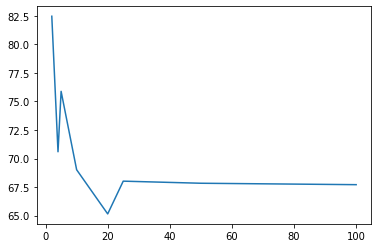

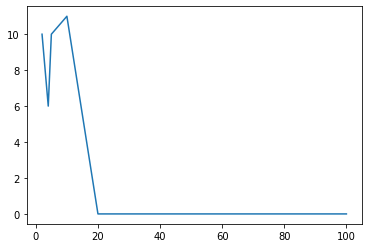

In [623]:
plt.plot(split_range, mses)
plt.show()
plt.plot(split_range, mse_mins);

2	42
12	37
22	36
32	37
42	37


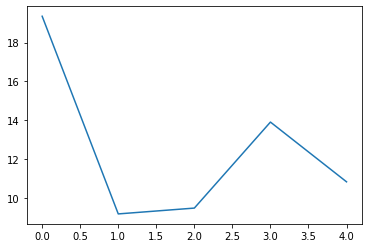

In [604]:
expected_cost = [expected_cost_sem(W_true, W) for W in Ws]
mses = []
for j in range(2, T - 1, 10):
    print(j, end = "\t")
    num_splits = j
    mses_avg = []
    for i in range(num_splits):
        k = range(i * T // num_splits, min((i + 1) * T // num_splits, T))

        if len(k) >= 1:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), 100 * [np.dot(y.T, y) for y in residuals_del], normalize = True, F = [], is_sem = True, tol = -1e-4)

            # print(np.shape(Ws))
            mses_avg.append([1 / (len(k)) * np.linalg.norm(X[k] - X[k] @ W, 'f') ** 2 for W in Ws])
            # print(np.shape(np.array([1 / (len(k)) * np.linalg.norm(X[k] - X[k] @ W, 'f') ** 2 for W in Ws])))
            # print(len(k), end = "\t")
        
    mses.append(np.linalg.norm(np.mean(np.array(mses_avg), axis = 0)[10:] - np.array(expected_cost)[10:], 2))
    print(np.argmin(np.mean(np.array(mses_avg), axis = 0)))
    
plt.plot(mses)

In [603]:
print(np.argmin(expected_cost))

34
